In [2]:
import csv
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

In [17]:
df_path = 'cleaned_final.csv'
df =  pd.read_csv(df_path, encoding='ISO-8859-1', index_col=0)
df = df.dropna(subset=['additionalInfo'])
df["additionalInfo"] = df["additionalInfo"].apply(lambda x: eval(x))
df = df[df["additionalInfo"].apply(lambda x: "Amenities" in x.keys())]

# Generate hotel characteristics (additional information)
n = df["additionalInfo"].apply(lambda x: x["Amenities"])
n = n.apply(lambda i: {k: v for d in i for k, v in d.items()})
df["freeWifi"] = n.apply(lambda i: i.get("Free Wi-Fi", None))
df["freeBreakfast"] = n.apply(lambda i: i.get("Free breakfast", None))
df["freeParking"] = n.apply(lambda i: i.get("Free parking", None))
df["pool"] = n.apply(lambda i: i.get("Pool", None))
df["restaurant"] = n.apply(lambda i: i.get("Restaurant", None))
df["fitnessCenter"] = n.apply(lambda i: i.get("Fitness center", None))

none_counts = {
    "freeWifi": df["freeWifi"].isna().sum(),
    "freeBreakfast": df["freeBreakfast"].isna().sum(),
    "freeParking": df["freeParking"].isna().sum(),
    "pool": df["pool"].isna().sum(),
    "restaurant": df["restaurant"].isna().sum(),
    "fitnessCenter": df["fitnessCenter"].isna().sum()
}
print(none_counts)

{'freeWifi': 340, 'freeBreakfast': 1960, 'freeParking': 2009, 'pool': 2036, 'restaurant': 772, 'fitnessCenter': 263}


In [18]:
# Select observations which have revnue at that time period
df = df[df["Total_Room_Receipts"] != 0]
df['revenue'] =  np.log(df['Total_Room_Receipts']+1)
by_hotel = df['hotelid']

# Convert 'PublishedAtDate' to datetime format
df['publishedAtDate'] = pd.to_datetime(df['publishedAtDate'], format='%Y%m')

# Create Threshold for later regressions
df['T'] = (df['actual_stars'] < df['present_stars']).astype(int)
actual_rating = df['actual_stars']

# PanelOls Setup
# Create entity and time indices
df_panel = df.set_index(['hotelid', 'publishedAtDate'])
rating = df_panel['present_stars']
actual_rating = df_panel['actual_stars']

# OLS Regressions
# Function to perform OLS regression and print the summary
def perform_ols(formula, data):
    model = ols(formula, data=data).fit()
    print(model.summary())

def run_regression(formula, data, regression_number):
    # Define the model
    model = PanelOLS.from_formula(formula, data)

    # Fit the model
    results = model.fit()

    # Print the summary of the regression results
    print(f"Regression {regression_number} Results")
    print("=" * 80)
    print(results)

In [19]:
df.head()

,publishedAtDate,title,address,city,state,totalScore,additionalInfo,reviewsCount,reviewsDistribution,hotelStars,...,Taxable_Receipts,hotelid,freeWifi,freeBreakfast,freeParking,pool,restaurant,fitnessCenter,revenue,T
0,2023-11-01,Sheraton Dallas Hotel,"400 Olive St, Dallas, TX 75201",Dallas,Texas,4.2,"{'Amenities': [{'Free Wi-Fi': True}, {'Breakfa...",5918.0,"{'oneStar': 308, 'twoStar': 242, 'threeStar': ...",4-star hotel,...,4407394.0,251.0,True,None,None,None,True,True,15.440556,0
1,2023-10-01,Sheraton Dallas Hotel,"400 Olive St, Dallas, TX 75201",Dallas,Texas,4.2,"{'Amenities': [{'Free Wi-Fi': True}, {'Breakfa...",5918.0,"{'oneStar': 308, 'twoStar': 242, 'threeStar': ...",4-star hotel,...,6235523.0,251.0,True,None,None,None,True,True,15.652235,0
2,2023-09-01,Sheraton Dallas Hotel,"400 Olive St, Dallas, TX 75201",Dallas,Texas,4.2,"{'Amenities': [{'Free Wi-Fi': True}, {'Breakfa...",5918.0,"{'oneStar': 308, 'twoStar': 242, 'threeStar': ...",4-star hotel,...,6077681.0,251.0,True,None,None,None,True,True,15.621185,0
3,2023-08-01,Sheraton Dallas Hotel,"400 Olive St, Dallas, TX 75201",Dallas,Texas,4.2,"{'Amenities': [{'Free Wi-Fi': True}, {'Breakfa...",5918.0,"{'oneStar': 308, 'twoStar': 242, 'threeStar': ...",4-star hotel,...,4320492.0,251.0,True,None,None,None,True,True,15.321711,0
4,2023-07-01,Sheraton Dallas Hotel,"400 Olive St, Dallas, TX 75201",Dallas,Texas,4.2,"{'Amenities': [{'Free Wi-Fi': True}, {'Breakfa...",5918.0,"{'oneStar': 308, 'twoStar': 242, 'threeStar': ...",4-star hotel,...,5280868.0,251.0,True,None,None,None,True,True,15.480553,0


In [20]:
df.dtypes

publishedAtDate                   datetime64[ns]
title                                     object
address                                   object
city                                      object
state                                     object
totalScore                               float64
additionalInfo                            object
reviewsCount                             float64
reviewsDistribution                       object
hotelStars                                object
url                                       object
stars                                    float64
reviewContained                          float64
reviewLength                             float64
ratingContained                          float64
actualRating                             float64
ratingReviewCumSum                       float64
reviewCumSum                             float64
actual_stars                             float64
present_stars                            float64
rev_index           

In [21]:
df.to_csv("~/Desktop/hoteldata_sample2.csv")

In [22]:
# Regression 1
perform_ols("revenue ~ present_stars", df)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     4213.
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:34   Log-Likelihood:                -5755.5
No. Observations:                3841   AIC:                         1.151e+04
Df Residuals:                    3839   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3460      0.126     34.440

In [23]:
# Regression 2
perform_ols("revenue ~ present_stars + hotelStars + C(publishedAtDate)", df)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     155.7
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:35   Log-Likelihood:                -3309.0
No. Observations:                3190   AIC:                             6698.
Df Residuals:                    3150   BIC:                             6941.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [24]:
# Regression 3
run_regression('revenue ~ rating + EntityEffects + TimeEffects', df_panel, 2)

Regression 2 Results
                          PanelOLS Estimation Summary                           
Dep. Variable:                revenue   R-squared:                      2.35e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0107
No. Observations:                3841   R-squared (Within):               0.0013
Date:                Sat, Mar 02 2024   R-squared (Overall):             -0.0106
Time:                        21:41:35   Log-likelihood                   -202.85
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0864
Entities:                         128   P-value                           0.7688
Avg Obs:                       30.008   Distribution:                  F(1,3678)
Min Obs:                       1.0000                                           
Max Obs:                       70.000   F-statistic (robust):             0.0864
       

In [25]:
# Regression 4
perform_ols("revenue ~ present_stars + C(fitnessCenter) + C(restaurant) + C(freeWifi) + C(publishedAtDate)", df)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     137.4
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:35   Log-Likelihood:                -3455.5
No. Observations:                2741   AIC:                             6987.
Df Residuals:                    2703   BIC:                             7212.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [26]:
# Regression Discontinuity
def rd_plot(df, bandwidth):
    df_plot = df[abs(df['actual_stars'] - df['present_stars']) <= bandwidth]
    df_plot["x_plot"] = round(df_plot["actual_stars"] - df_plot["present_stars"], 3)
    df_plot['revenue_demean'] = df_plot['revenue'] - df_plot['revenue'].mean()
    plot_f = df_plot.groupby(df_plot["x_plot"]).agg({"revenue_demean": np.mean, "actual_stars": np.mean})
    threshold = 0
    x = np.array(plot_f.index)
    y = plot_f["revenue_demean"]
    
    # Extract control variable from DataFrame
    control_variable = plot_f['actual_stars']  # Change 'control_variable_column_name' to the actual column name
    
    # Stack the threshold variable and control variable horizontally
    X = np.column_stack((x, control_variable))
    
    # Fit regression models on either side of the threshold
    model_left = LinearRegression().fit(X[x <= threshold], y[x <= threshold])
    model_right = LinearRegression().fit(X[x > threshold], y[x > threshold])

    # Predict values for a smooth line
    x_values = np.linspace(x.min(), x.max(), 1000)
    X_values = np.column_stack((x_values, np.repeat(control_variable.mean(), len(x_values))))  # Use mean of control variable for prediction
    y_pred_left = model_left.predict(X_values[x_values <= threshold])
    y_pred_right = model_right.predict(X_values[x_values > threshold])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5, label='Data points')
    plt.plot(x_values[x_values <= threshold], y_pred_left, color='red', label='Left of threshold fit')
    plt.plot(x_values[x_values > threshold], y_pred_right, color='blue', label='Right of threshold fit')
    plt.axvline(x=threshold, color='green', linestyle='--', label='Threshold')

    # Labeling the plot
    plt.title('RDD-like Scatter Plot with Fitted Regression Lines')
    plt.xlabel('Distance from Threshold')
    plt.ylabel('Revenue(log)')
    plt.legend()
    plt.show()

/var/folders/8m/8by7qkhx3n5fnnpb_stj_97m0000gn/T/ipykernel_45507/1295735747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["x_plot"] = round(df_plot["actual_stars"] - df_plot["present_stars"], 3)
/var/folders/8m/8by7qkhx3n5fnnpb_stj_97m0000gn/T/ipykernel_45507/1295735747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['revenue_demean'] = df_plot['revenue'] - df_plot['revenue'].mean()


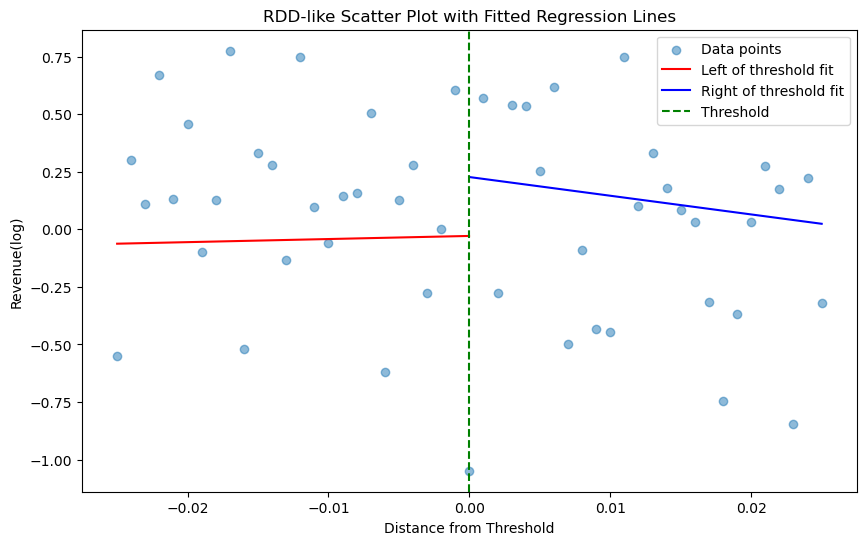

In [27]:
rd_plot(df,0.025)

/var/folders/8m/8by7qkhx3n5fnnpb_stj_97m0000gn/T/ipykernel_45507/1295735747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["x_plot"] = round(df_plot["actual_stars"] - df_plot["present_stars"], 3)
/var/folders/8m/8by7qkhx3n5fnnpb_stj_97m0000gn/T/ipykernel_45507/1295735747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['revenue_demean'] = df_plot['revenue'] - df_plot['revenue'].mean()


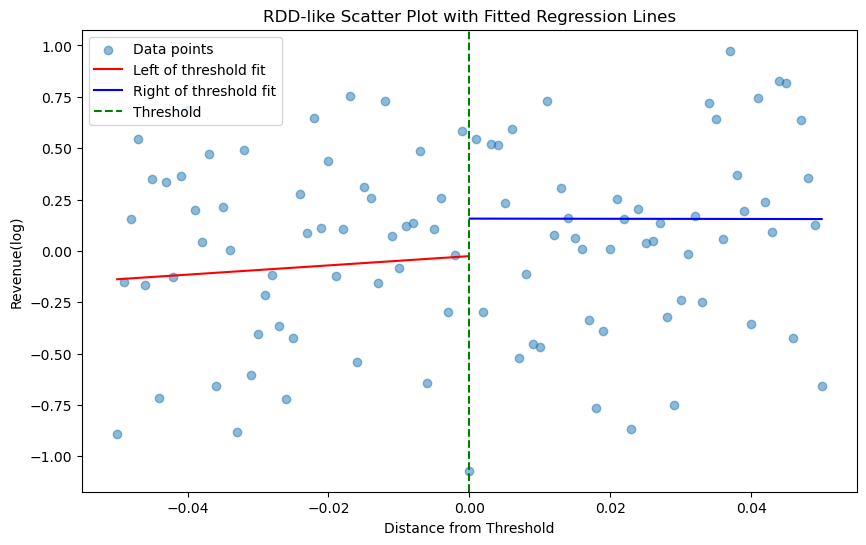

In [28]:
rd_plot(df,0.05)

In [29]:
# Regression Discontinuity
#3 kinds: 0.05, 0.025, 0.02(all data, which is df itself)
def perform_rd_analysis(data, bandwidth, formula):
    # Filter the data based on the specified bandwidth
    df_rd = data[abs(data['actual_stars'] - data['present_stars']) <= bandwidth]

    # Perform OLS regression
    model = ols(formula, data=df_rd).fit()
    print(f"Regression Discontinuity Analysis for Bandwidth: {bandwidth}")
    print(model.summary())

# With different bandwidths and formulas
# Functions of formula = 'revenue ~ T + actual_stars + C(hotelStars) + C(publishedAtDate)'
# RD Analysis for Bandwidth 0.05
perform_rd_analysis(df, 0.05, "revenue ~ T + actual_stars + C(hotelStars) + C(publishedAtDate)")

Regression Discontinuity Analysis for Bandwidth: 0.05
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     153.1
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:37   Log-Likelihood:                -3297.8
No. Observations:                3188   AIC:                             6678.
Df Residuals:                    3147   BIC:                             6926.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [30]:
# RD Analysis for Bandwidth 0.025
perform_rd_analysis(df, 0.025, "revenue ~ T + actual_stars + C(hotelStars) + C(publishedAtDate)")

Regression Discontinuity Analysis for Bandwidth: 0.025
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     91.22
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:41   Log-Likelihood:                -1764.3
No. Observations:                1716   AIC:                             3611.
Df Residuals:                    1675   BIC:                             3834.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [31]:
# RD Analysis for Bandwidth 0.02
perform_rd_analysis(df, 0.02, "revenue ~ T + actual_stars + C(hotelStars) + C(publishedAtDate)")

Regression Discontinuity Analysis for Bandwidth: 0.02
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     82.51
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:41   Log-Likelihood:                -1361.8
No. Observations:                1362   AIC:                             2806.
Df Residuals:                    1321   BIC:                             3019.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [39]:
# Functions of formula = 'revenue ~ T + actual_stars + C(fitnessCenter) + C(restaurant) + C(freeWifi) + C(publishedAtDate)'
# 3 Amenities features
# RD Analysis for Bandwidth 0.05
perform_rd_analysis(df, 0.05, "revenue ~ T + actual_stars + C(fitnessCenter) + C(restaurant) + C(freeWifi) + C(publishedAtDate)")

Regression Discontinuity Analysis for Bandwidth: 0.05
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     135.8
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:51:02   Log-Likelihood:                -3430.4
No. Observations:                2737   AIC:                             6939.
Df Residuals:                    2698   BIC:                             7170.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [40]:
# RD Analysis for Bandwidth 0.025
perform_rd_analysis(df, 0.025, "revenue ~ T + actual_stars + C(fitnessCenter) + C(restaurant) + C(freeWifi) + C(publishedAtDate)")

Regression Discontinuity Analysis for Bandwidth: 0.025
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     70.76
Date:                Sat, 02 Mar 2024   Prob (F-statistic):          2.76e-296
Time:                        21:51:03   Log-Likelihood:                -1803.8
No. Observations:                1462   AIC:                             3686.
Df Residuals:                    1423   BIC:                             3892.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [41]:
# RD Analysis for Bandwidth 0.02
perform_rd_analysis(df, 0.02, "revenue ~ T + actual_stars + C(fitnessCenter) + C(restaurant) + C(freeWifi) + C(publishedAtDate)")

Regression Discontinuity Analysis for Bandwidth: 0.02
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     55.75
Date:                Sat, 02 Mar 2024   Prob (F-statistic):          2.15e-229
Time:                        21:51:04   Log-Likelihood:                -1455.1
No. Observations:                1170   AIC:                             2988.
Df Residuals:                    1131   BIC:                             3186.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [42]:
#heterogeneous effects (reviews as noise - interaction term: reviewContained, reviewLength)
# Version of using ols
perform_ols('revenue ~ T + present_stars + reviewLength + present_stars:reviewLength', df)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1196.
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:45:52   Log-Likelihood:                -5623.0
No. Observations:                3841   AIC:                         1.126e+04
Df Residuals:                    3836   BIC:                         1.129e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
perform_ols('revenue ~ T + present_stars + reviewContained + present_stars:reviewContained', df)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     1494.
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:41:42   Log-Likelihood:                -5374.2
No. Observations:                3841   AIC:                         1.076e+04
Df Residuals:                    3836   BIC:                         1.079e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [37]:
# Version of using panelOls
run_regression('revenue ~ T + rating + reviewLength + rating:reviewLength + EntityEffects + TimeEffects', df_panel, 4)

Regression 4 Results
                          PanelOLS Estimation Summary                           
Dep. Variable:                revenue   R-squared:                        0.0023
Estimator:                   PanelOLS   R-squared (Between):             -0.0445
No. Observations:                3841   R-squared (Within):               0.0034
Date:                Sat, Mar 02 2024   R-squared (Overall):             -0.0441
Time:                        21:41:43   Log-likelihood                   -198.54
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.0866
Entities:                         128   P-value                           0.0799
Avg Obs:                       30.008   Distribution:                  F(4,3675)
Min Obs:                       1.0000                                           
Max Obs:                       70.000   F-statistic (robust):             2.0866
       

In [38]:
run_regression('revenue ~ T + rating + reviewContained + rating:reviewContained + EntityEffects + TimeEffects', df_panel, 5)

Regression 5 Results
                          PanelOLS Estimation Summary                           
Dep. Variable:                revenue   R-squared:                        0.0205
Estimator:                   PanelOLS   R-squared (Between):              0.0350
No. Observations:                3841   R-squared (Within):               0.0147
Date:                Sat, Mar 02 2024   R-squared (Overall):              0.0348
Time:                        21:41:43   Log-likelihood                   -163.16
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      19.205
Entities:                         128   P-value                           0.0000
Avg Obs:                       30.008   Distribution:                  F(4,3675)
Min Obs:                       1.0000                                           
Max Obs:                       70.000   F-statistic (robust):             19.205
       